In [44]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches


# Spotlight PA Demonstration

Note: This notebook will accompany the Case Study #1 article

## Download Relevant Data

[Data Set #1 (without prisoner reallocation)](https://redistrictingdatahub.org/dataset/pennsylvania-block-pl-94-171-2020-official-without-prisoner-reallocation/)
- Note: This dataset was used for congressional redistricting

[Data Set #2 (with prisoner reallocation)](https://redistrictingdatahub.org/dataset/pennsylvania-block-pl-94-171-2020-official-prison-adjusted/)
- Note: This dataset was used for state legislative redistricting

[2020 PA L2 Voterfile Data on P.L. Block Geographies](https://redistrictingdatahub.org/dataset/2021-pennsylvania-l2-voter-file-aggregated-to-2020-census-blocks/), [by table](https://redistrictingdatahub.org/dataset/pennsylvania-block-pl-94171-2020-by-table/)
- Note: This dataset will be used to get party-registration data for each district

[2020 Census Block-Level Data](https://redistrictingdatahub.org/dataset/pennsylvania-block-pl-94171-2020/)
- Note: This dataset will be used for the block-assignments for the old districts and for demographic data for the congressional districts. For state legislative districts, we'll use the prisoner reallocated data allocated to the old district geometries
- You should download the .csv version of this file
- I renamed the folder "pa_pl2020_b_csv" to distinguish from the below file

[2020 Census Block-Level Data](https://redistrictingdatahub.org/dataset/pennsylvania-block-pl-94171-2020-by-table/)
- Note: This is a smaller version of the above dataset. We use this smaller version to grab the shapefile and demographic data for PA.
- You should download the .shp version of this file

[New State House District Block-Assignment File](https://davesredistricting.org/maps#state::PA)  
[New State Senate District Block-Assignment File](https://davesredistricting.org/maps#state::PA)  
[New Congressional District Block-Assignment File](https://davesredistricting.org/maps#state::PA) 
- Note: For these files, you'll need to have an account with DRA. Navigate to each of the three links above, and open up each of the three official maps. On each map, click the arrow pointing to the upper-right, check "Export alternate census blocks" and export the block assignment files. 
- For the purposes of folder structure, I've renamed these files, block-assignment-pa-sldl, block-assignment-pa-sldu, and block-assignment-pa-cong respectively

In whatever directory you are working in, creating a folder named "raw-from-source" and put the above files in them. For any zipped files (the first four in the above list) you should unzip them

After making the name changes to the block-assignment files (being sure to rename the right files), you should have a "raw-from-source" folder with the following files / folders:

- block-assignments-pa-cong.csv
- block-assignments-pa-sldl.csv
- block-assignments-pa-sldu.csv
- PA_L2_2020BlockAgg
- pa_pl2020_b
- pa_pl2020_b_csv
- pa_pl2020_block_noreallocation
- pa_pl2020_official_blocks

## Load in Relevant Files

In [2]:
# Load the block assignment files
cong_baf = pd.read_csv("./raw-from-source/block-assignments-pa-cong.csv")
sldl_baf = pd.read_csv("./raw-from-source/block-assignments-pa-sldl.csv")
sldu_baf = pd.read_csv("./raw-from-source/block-assignments-pa-sldu.csv")

# Load the voter file data
pa_voterfile = pd.read_csv("./raw-from-source/PA_L2_2020BlockAgg/PA_l2_2020block_agg_20210902.csv")

# Load in the P2 table of the PL data
pa_pl_census = gp.read_file("./raw-from-source/pa_pl2020_b/pa_pl2020_p2_b.shp")

# Load in the csv version of the PL data
pa_pl_census_csv = pd.read_csv("./raw-from-source/pa_pl2020_b_csv/pa_pl2020_b.csv")

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55948/3404305616.py:13: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  pa_pl_census_csv = pd.read_csv("./raw-from-source/pa_pl2020_b_csv/pa_pl2020_b.csv")


### Join the PL Data Together

In [3]:
# Filter the PL csv to the needed columns
pa_pl_census_csv = pa_pl_census_csv[["GEOCODE", "CD116", "SLDL18", "SLDU18"]]

# Rename the GEOCODE column to match the other PL file
pa_pl_census_csv.rename(columns = {"GEOCODE":"GEOID20"}, inplace = True)

# Change the column type to match the other PL file
pa_pl_census_csv["GEOID20"] = pa_pl_census_csv["GEOID20"].astype(str)

# Join the two files together
pa_pl_census = gp.GeoDataFrame(pd.merge(pa_pl_census_csv, pa_pl_census, how = "inner", on = "GEOID20"))

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55948/1318649540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pa_pl_census_csv.rename(columns = {"GEOCODE":"GEOID20"}, inplace = True)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55948/1318649540.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pa_pl_census_csv["GEOID20"] = pa_pl_census_csv["GEOID20"].astype(str)


## Look into differences with PA's modified file

Note: We exported the modified census blocks for all the block assignment files

In [4]:
# Cast the GEOCODE to string to match the baf
pa_pl_census["GEOID20"] = pa_pl_census["GEOID20"].astype(str)

# Notice that there are 54 more census blocks in PA's modified file
print(pa_pl_census.shape[0])
print(cong_baf.shape[0])

# There are 53 census blocks that are only in the PL file and 107 blocks only in the modified file
print(len(set(pa_pl_census["GEOID20"]) - set(cong_baf["GEOID20"])))
print(len(set(cong_baf["GEOID20"]) - set(pa_pl_census["GEOID20"])))

336985
337039
53
107


If you take a closer look, you can see that 52 of the 53 blocks are split into "a" and "b" parts and 1 block is split into an "a", "b" and a "c".  

For a total of 52 * 2 + 1 * 3 = 107 blocks

In [5]:
set(pa_pl_census["GEOID20"]) - set(cong_baf["GEOID20"])

{'420912003017006',
 '420912003017026',
 '420912003017031',
 '420912003072001',
 '420912003072002',
 '420912003092014',
 '420912005073006',
 '420912016072017',
 '420912018001015',
 '420912019024010',
 '420912025002022',
 '420912026022000',
 '420912032032025',
 '420912033021010',
 '420912033022003',
 '420912033022010',
 '420912033022019',
 '420912033022021',
 '420912033022024',
 '420912033022027',
 '420912033031001',
 '420912049003011',
 '420912061041008',
 '420912061042001',
 '420912061062006',
 '420912061062010',
 '420912061062012',
 '420912078002001',
 '420912078002002',
 '420912078002003',
 '420912078002004',
 '420912078002006',
 '420912078003020',
 '420912078004002',
 '420912078004030',
 '420912078004037',
 '420912086041002',
 '420912087041000',
 '420912105003007',
 '420912105003010',
 '421010119002007',
 '421010207011002',
 '421010207011009',
 '421010207012008',
 '421010255001004',
 '421010257002008',
 '421010341003001',
 '421019804001000',
 '421019809011000',
 '421019809011005',


In [6]:
set(cong_baf["GEOID20"]) - set(pa_pl_census["GEOID20"])

{'420912003017006A',
 '420912003017006B',
 '420912003017026A',
 '420912003017026B',
 '420912003017031A',
 '420912003017031B',
 '420912003072001A',
 '420912003072001B',
 '420912003072002A',
 '420912003072002B',
 '420912003092014A',
 '420912003092014B',
 '420912005073006A',
 '420912005073006B',
 '420912016072017A',
 '420912016072017B',
 '420912018001015A',
 '420912018001015B',
 '420912019024010A',
 '420912019024010B',
 '420912025002022A',
 '420912025002022B',
 '420912026022000A',
 '420912026022000B',
 '420912032032025A',
 '420912032032025B',
 '420912033021010A',
 '420912033021010B',
 '420912033022003A',
 '420912033022003B',
 '420912033022010A',
 '420912033022010B',
 '420912033022019A',
 '420912033022019B',
 '420912033022021A',
 '420912033022021B',
 '420912033022024A',
 '420912033022024B',
 '420912033022027A',
 '420912033022027B',
 '420912033031001A',
 '420912033031001B',
 '420912049003011A',
 '420912049003011B',
 '420912061041008A',
 '420912061041008B',
 '420912061042001A',
 '42091206104

For each of the block assignment files, confirm that these split blocks are drawn into the same district. If this is the case, because we aggregating the data, we can "combine" the blocks and undo the split for the purposes of this analysis

In [7]:
# Add in a column with the length of the GEOID
cong_baf["id_len"] = cong_baf["GEOID20"].apply(lambda x: len(x))
sldl_baf["id_len"] = sldl_baf["GEOID20"].apply(lambda x: len(x))
sldu_baf["id_len"] = sldu_baf["GEOID20"].apply(lambda x: len(x))

In [8]:
# As you can see, these are the 107 blocks
print(cong_baf["id_len"].value_counts())
print(sldl_baf["id_len"].value_counts())
print(sldu_baf["id_len"].value_counts())

15    336932
16       107
Name: id_len, dtype: int64
15    336932
16       107
Name: id_len, dtype: int64
15    336932
16       107
Name: id_len, dtype: int64


In [9]:
split_block_ids = list(set(cong_baf["GEOID20"]) - set(pa_pl_census["GEOID20"]))

In [10]:
# Run code to check if there are any differing assignments for these blocks
for block_id in split_block_ids:
    '''
    Filtering the baf to those blocks involved in the split and seeing how many unique district values
    those blocks have, if there is more than one, print something out highlighting that block
    '''
    if cong_baf[cong_baf["GEOID20"].str.contains(block_id[:len(block_id)-1])]["District"].value_counts().shape[0] != 1:
        print("Split involving", block_id, "for the congressional map")
    if sldl_baf[sldl_baf["GEOID20"].str.contains(block_id[:len(block_id)-1])]["District"].value_counts().shape[0] != 1:
        print("Split involving", block_id, "for the state house map")
    if sldu_baf[sldu_baf["GEOID20"].str.contains(block_id[:len(block_id)-1])]["District"].value_counts().shape[0] != 1:
        print("Split involving", block_id, "for the state senate map")

In [11]:
# Edit the block assignment files to combine the split blocks

In [12]:
cong_baf["GEOID20"] = cong_baf["GEOID20"].str[0:15]
cong_baf.drop_duplicates(inplace = True)

sldl_baf["GEOID20"] = sldl_baf["GEOID20"].str[0:15]
sldl_baf.drop_duplicates(inplace = True)

sldu_baf["GEOID20"] = sldu_baf["GEOID20"].str[0:15]
sldu_baf.drop_duplicates(inplace = True)

In [13]:
cong_baf_dict = dict(zip(cong_baf["GEOID20"], cong_baf["District"]))
sldl_baf_dict = dict(zip(sldl_baf["GEOID20"], sldl_baf["District"]))
sldu_baf_dict = dict(zip(sldu_baf["GEOID20"], sldu_baf["District"]))

In [14]:
# Since there are no changes to the census data in PA's modified, unre-allocated data, we don't need to use that

## Clean the voterfile data

In [15]:
# Take a look at the voterfile data and filter to needed columns
print(pa_voterfile.head())

# Note there are a good deal of blocks not in the file, (because they don't have a registered voter)
print(pa_voterfile.shape[0])

# Filter the voterfile down to the columns we are interested in
print(pa_voterfile.columns)

# We will need the geoid column to join the data, and then the dem, rep, and total registration data
pa_voterfile = pa_voterfile[['geoid20','total_reg', 'party_dem', 'party_rep']]

# Rename the GEOID20 columns to match the others
pa_voterfile.rename(columns={'geoid20':'GEOID20'}, inplace = True)

           geoid20  total_reg  age_18_19  age_20_24  age_25_29  age_30_34  \
0  420010314014003        134          1          4          6          8   
1  420034803001010         52          1          4          2          5   
2  420034801014003        105          1          8          4          7   
3  420034315003011        229          0         15         11         26   
4  420035190002007         53          0          3          2          4   

   age_35_44  age_45_54  age_55_64  age_65_74  ...  p20140520  g20131105  \
0         17         13         28         39  ...         20         36   
1          6         10          4          8  ...         13         17   
2         20         18          9         16  ...          5          4   
3         30         17         45         44  ...         35         37   
4          5          5          5         14  ...          3          7   

   p20130521  g20121106  pp20120424  p20120424  g20111108  p20110517  \
0       

In [16]:
pa_voterfile["GEOID20"] = pa_voterfile["GEOID20"].astype(str)

## Clean the demographic data

From their tool, it looks like Spotlight is tracking asian, black, hispanic, white, mixed race, and other as their racial / ethnic demographic categories

If you look at our [Fields and Description](https://redistrictingdatahub.org/data/about-our-data/pl-94171-dataset/fields-and-descriptions/) page, you can see the relevant columns for this data
- P0020001: Total population
- P0020008: Asian (Non-hispanic)
- P0020006: Black or African American alone (Non-hispanic)
- P0020002: Hispanic or Latino
- P0020005: White alone (Non-hispanic)
- P0020011: Two or more races (Non-hispanic)

Note: For the "other" category, we'll subtract the other categories from the total population

In [17]:
# Define a list with the needed columns
demo_columns = ['P0020001', 'P0020008', 'P0020006', 'P0020002', 'P0020005', 'P0020011']

In [18]:
# Filter the pl census file
pa_pl_census = gp.GeoDataFrame(pa_pl_census[["GEOID20", "CD116", "SLDL18", "SLDU18"] + demo_columns + ["geometry"]].copy(deep = True))

# Filter PA's modified census dataframes
#pa_mod_reall = pa_mod_reall[["GEOID20"] + demo_columns]

In [19]:
# Join the voterfile to the two dataframes
joined_pl_data = pd.merge(pa_pl_census, pa_voterfile, how = "outer", on = "GEOID20", indicator = True)

In [20]:
joined_pl_data["_merge"].value_counts()

both          270345
left_only      66640
right_only         0
Name: _merge, dtype: int64

In [21]:
joined_pl_data["new_cong"] = joined_pl_data["GEOID20"].map(cong_baf_dict).fillna("N/A")
joined_pl_data["new_sldl"] = joined_pl_data["GEOID20"].map(sldl_baf_dict).fillna("N/A")
joined_pl_data["new_sldu"] = joined_pl_data["GEOID20"].map(sldu_baf_dict).fillna("N/A")

## Add the prisoner-adjusted data


In [22]:
# Load in the data
pa_mod_reall = gp.read_file("./raw-from-source/pa_pl2020_official_blocks/WP_Blocks.shp")

# Make a list of the columns needed 
reall_columns = ['P0010001', 'P0020008', 'P0020006', 'P0020002', 'P0020005', 'P0020011']

# Filter down to the needed columns
pa_mod_reall = pa_mod_reall[["GEOID20"] + reall_columns].copy(deep = True)

# Create a column related to the length of the GEOID column
pa_mod_reall["id_len"] = pa_mod_reall["GEOID20"].apply(lambda x: len(x))

# Expecting 107 blocks with a length of 16
print(pa_mod_reall["id_len"].value_counts())

# Edit the GEOID20 file to clean the splits
pa_mod_reall["GEOID20"] = pa_mod_reall["GEOID20"].str[0:15]

# Expecting some duplicates here
pa_mod_reall["GEOID20"].value_counts()

15    336932
16       107
Name: id_len, dtype: int64


420912087041000    3
420912086041002    2
420912061062012    2
420912061062006    2
421019809013009    2
                  ..
421330208013018    1
420410124002044    1
420410121001004    1
420410103001037    1
421010286003015    1
Name: GEOID20, Length: 336985, dtype: int64

In [23]:
# Aggregate the data to the PL blocks
pa_mod_reall_cleaned = pa_mod_reall.groupby("GEOID20").sum()

# Clean the indices
pa_mod_reall_cleaned.reset_index(inplace = True, drop = False)

# Create a dictionary to rename the columns
reall_dict = {i: i+"_adj" for i in reall_columns}

# Rename the columns
pa_mod_reall_cleaned.rename(columns=reall_dict, inplace = True)

### Join the Prisoner-Adjusted Data to the Other DataFrame

In [24]:
# Drop the merge column
joined_pl_data.drop("_merge", axis = 1, inplace = True)

# Join the prisoner-adjusted data to the other dataset
final_join = gp.GeoDataFrame(pd.merge(pa_mod_reall_cleaned, joined_pl_data, on = "GEOID20", indicator = True))

In [25]:
final_join.drop(["_merge", "id_len"], axis = 1, inplace = True)

### Create the Aggregated Files

In [26]:
# Create the files on 
old_cong = final_join.dissolve("CD116", aggfunc = "sum")
old_sldl = final_join.dissolve("SLDL18", aggfunc = "sum")
old_sldu = final_join.dissolve("SLDU18", aggfunc = "sum")
new_cong = final_join.dissolve("new_cong", aggfunc = "sum")
new_sldl = final_join.dissolve("new_sldl", aggfunc = "sum")
new_sldu = final_join.dissolve("new_sldu", aggfunc = "sum")

### Clean the Aggregated Files

In [27]:
# Create the columns
def create_data_columns(df):
    
    # Define the voter registration columns
    df["Reg_DEM"] = df["party_dem"] / df["total_reg"]
    df["Reg_REP"] = df["party_rep"] / df["total_reg"]
    df["Reg_OTH"] = (df["total_reg"]-df["party_dem"]-df["party_rep"]) / df["total_reg"]
    
    # Define the demographic columns
    df["Demo_ASIAN"] = df["P0020008"] / df["P0020001"]
    df["Demo_WHITE"] = df["P0020005"] / df["P0020001"]
    df["Demo_BLACK"] = df["P0020006"] / df["P0020001"]
    df["Demo_HISPANIC"] = df["P0020002"] / df["P0020001"]
    df["Demo_MIXED"] = df["P0020011"] / df["P0020001"]
    df["Demo_OTHER"] = (df["P0020001"] - df["P0020008"] - df["P0020005"] 
                        - df["P0020006"] - df["P0020002"] - df["P0020011"])  / df["P0020001"]
    
    return df

In [28]:
# Create the demographic columns for the adjusted data
def create_adj_data_columns(df):
        
    # Define the demographic columns
    df["Demo_ASIAN_adj"] = df["P0020008_adj"] / df["P0010001_adj"]
    df["Demo_WHITE_adj"] = df["P0020005_adj"] / df["P0010001_adj"]
    df["Demo_BLACK_adj"] = df["P0020006_adj"] / df["P0010001_adj"]
    df["Demo_HISPANIC_adj"] = df["P0020002_adj"] / df["P0010001_adj"]
    df["Demo_MIXED_adj"] = df["P0020011_adj"] / df["P0010001_adj"]
    df["Demo_OTHER_adj"] = (df["P0010001_adj"] - df["P0020008_adj"] - df["P0020005_adj"] 
                        - df["P0020006_adj"] - df["P0020002_adj"] - df["P0020011_adj"])  / df["P0010001_adj"]
    
    return df

In [29]:
def add_needed_columns(df):
    return format_percentages(create_adj_data_columns(create_data_columns(df)))

In [30]:
def format_percentages(dataframe):
    for col_name in ["Reg_DEM", "Reg_REP", "Reg_OTH", "Demo_ASIAN","Demo_WHITE","Demo_BLACK","Demo_HISPANIC","Demo_MIXED","Demo_OTHER",
"Demo_ASIAN_adj","Demo_WHITE_adj","Demo_BLACK_adj","Demo_HISPANIC_adj","Demo_MIXED_adj","Demo_OTHER_adj"]:
        dataframe[col_name] = dataframe[col_name].map('{:.1%}'.format)
    return dataframe

In [31]:
# Call the above functions on the six files we created
old_cong = add_needed_columns(old_cong)
new_cong = add_needed_columns(new_cong)
old_sldl = add_needed_columns(old_sldl)
new_sldl = add_needed_columns(new_sldl)
old_sldu = add_needed_columns(old_sldu)
new_sldu = add_needed_columns(new_sldu)

## Create Maps

These appear in the case study write-up we have up on the site.

### Map #1 - Percent Registered Democrats by PA 2022 Congressional District

In [32]:
# Clean up the index in the new_cong file
new_cong.reset_index(drop = False, inplace = True)

# Turn the registered democrats column into a number so it can be part of a color map
new_cong['Reg_DEM'] = new_cong['Reg_DEM'].str.replace("%","")
new_cong['Reg_DEM'] = new_cong['Reg_DEM'].astype(float)

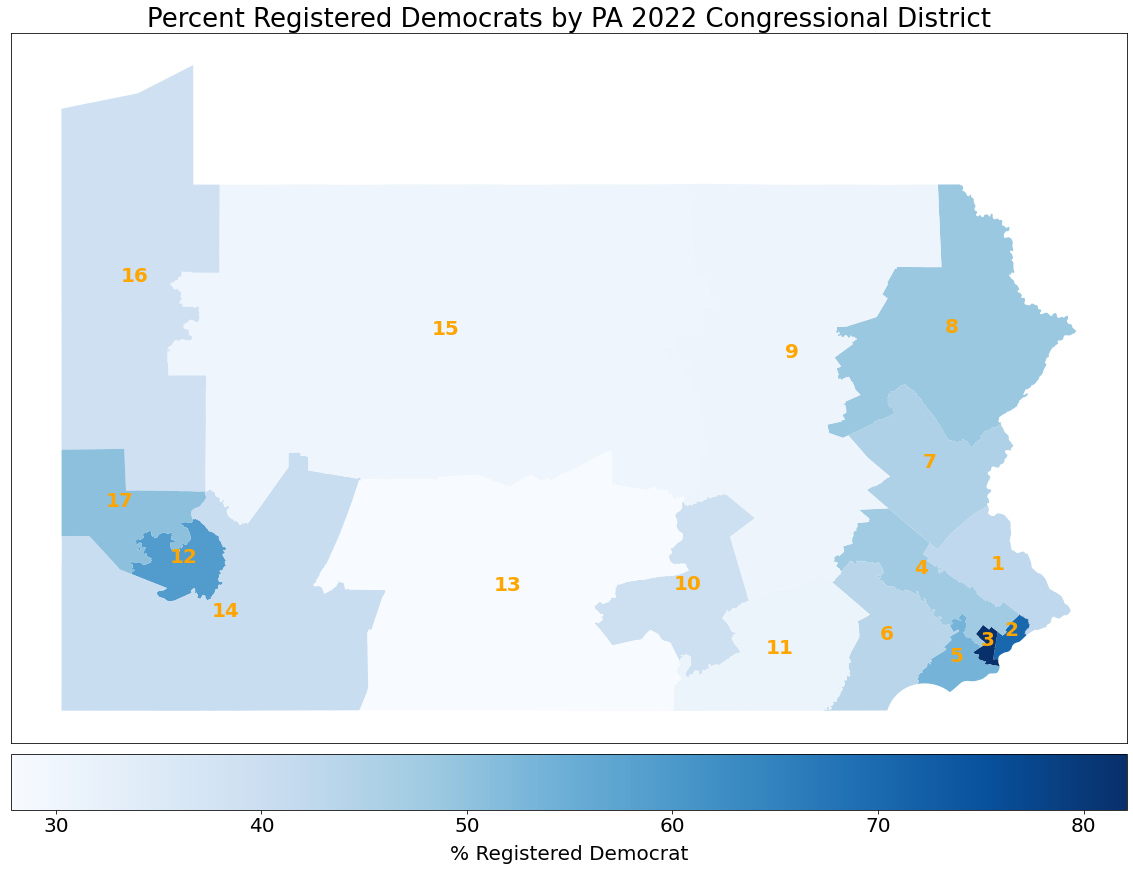

In [33]:
plt = new_cong.plot(figsize = (20,20), column = 'Reg_DEM', cmap ="Blues", legend = True, legend_kwds={'orientation': "horizontal", "pad": 0.01} )
plt.set_title("Percent Registered Democrats by PA 2022 Congressional District", size = 26)
new_cong.apply(lambda x: plt.annotate(text=x["new_cong"], xy=x.geometry.centroid.coords[0], ha='center', fontsize = 20, color = "orange", weight='bold'), axis=1, );
plt.xaxis.set_visible(False)
plt.yaxis.set_visible(False)
fig = plt.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=20)
cb_ax.set_title("% Registered Democrat", fontsize=20, y = -1)
plt.figure.savefig("./example_map_dem.png",bbox_inches="tight")

### Map #2 - Percent Registered Republicans by PA 2022 Congressional District

In [34]:
# Turn the registered democrats column into a number so it can be part of a color map
new_cong['Reg_REP'] = new_cong['Reg_REP'].str.replace("%","")
new_cong['Reg_REP'] = new_cong['Reg_REP'].astype(float)

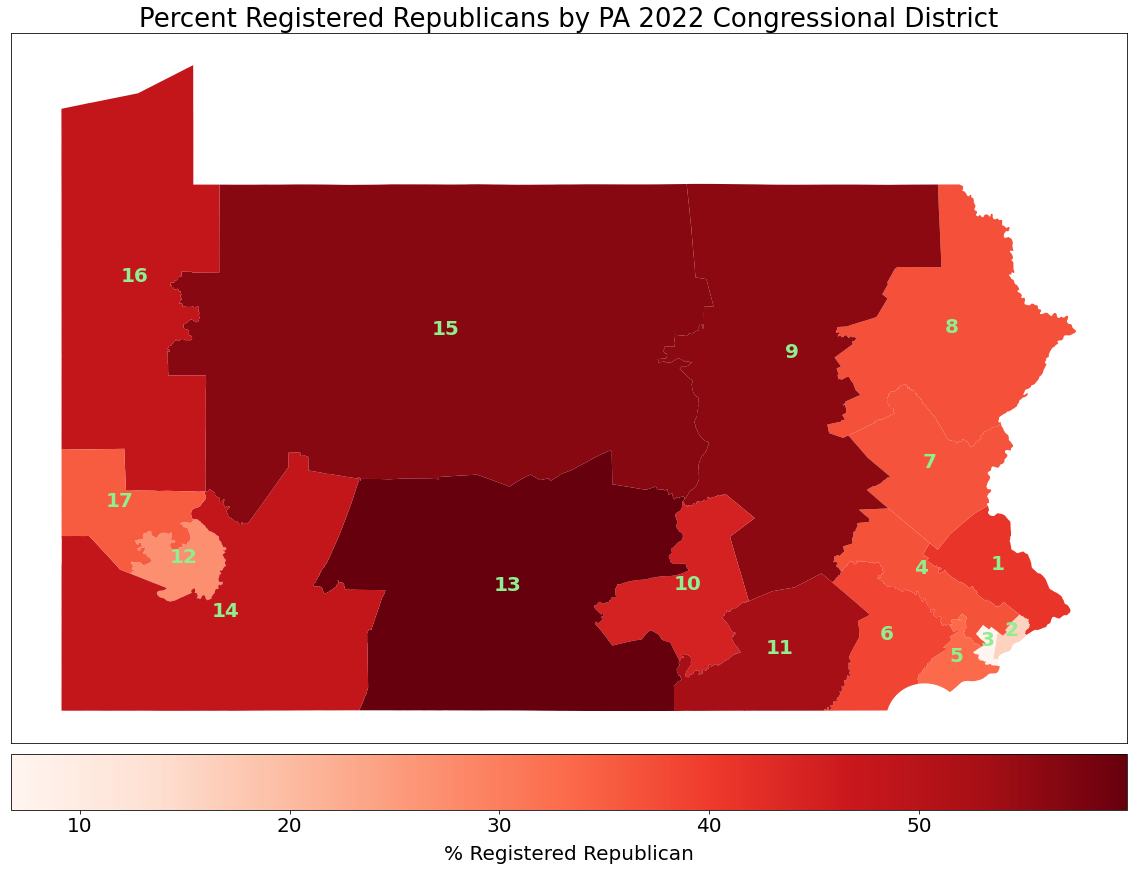

In [38]:
plt = new_cong.plot(figsize = (20,20), column = 'Reg_REP', cmap ="Reds", legend = True, legend_kwds={'orientation': "horizontal", "pad": 0.01} )
plt.set_title("Percent Registered Republicans by PA 2022 Congressional District", size = 26)
new_cong.apply(lambda x: plt.annotate(text=x["new_cong"], xy=x.geometry.centroid.coords[0], ha='center', fontsize = 20, color = "lightgreen", weight='bold'), axis=1, );
plt.xaxis.set_visible(False)
plt.yaxis.set_visible(False)
fig = plt.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=20)
cb_ax.set_title("% Registered Republican", fontsize=20, y = -1)
plt.figure.savefig("./example_map_rep.png",bbox_inches="tight")

### Map #3 - Census Block Split Example

In [39]:
# Load the adjusted geometries
pa_adjusted_geoms = gp.read_file("./raw-from-source/pa_pl2020_block_noreallocation/WP_Blocks.shp")

# Load in the P2 table of the PL data
pa_pl_census = gp.read_file("./raw-from-source/pa_pl2020_b/pa_pl2020_p2_b.shp")

# Load in the csv version of the PL data
pa_pl_census_csv = pd.read_csv("./raw-from-source/pa_pl2020_b_csv/pa_pl2020_b.csv")

# Change the column type to match the other PL file
pa_pl_census_csv["GEOID20"] = pa_pl_census_csv["GEOID20"].astype(str)

# Join the two files together
pa_pl_census = gp.GeoDataFrame(pd.merge(pa_pl_census_csv, pa_pl_census, how = "inner", on = "GEOID20"))

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_55948/874939912.py:8: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  pa_pl_census_csv = pd.read_csv("./raw-from-source/pa_pl2020_b_csv/pa_pl2020_b.csv")


In [40]:
# Take a look at one of the split blocks in the PA modified file, note the VTD column
pa_adjusted_geoms[pa_adjusted_geoms["GEOID20"].str.contains('420912078003020')]

,FIPS,VTD,TRACT,BLOCK,LOGRECNO,P0010001,P0010002,P0010003,P0010004,P0010005,...,INTPTLAT20,INTPTLON20,COUNTY_NME,MCD_NUMBER,MCD_NAME,MCD_TYP_NM,MCD_TYP_CD,VTD_NAME,BLKGRP,geometry
306981,091,003250,207800,3020A,434039_003250,2,1,1,0,0,...,+40.4065308,-075.5456357,Montgomery,79064,UPPER HANOVER,TOWNSHIP,4,UPPER HANOVER DISTRICT 02,3,"POLYGON ((-75.54318 40.40727, -75.54629 40.405..."
319447,091,003260,207800,3020B,434039_003260,4,2,2,0,0,...,+40.4065308,-075.5456357,Montgomery,79064,UPPER HANOVER,TOWNSHIP,4,UPPER HANOVER DISTRICT 03,3,"POLYGON ((-75.54318 40.40727, -75.54393 40.407..."


In [41]:
# Take a look at the block in the original PL file
pa_pl_census[pa_pl_census["GEOID20"].str.contains('420912078003020')]

,FILEID,STUSAB,SUMLEV_x,GEOVAR,GEOCOMP,CHARITER,LOGRECNO_x,GEOID_x,GEOCODE,REGION,...,P0020065_y,P0020066_y,P0020067_y,P0020068_y,P0020069_y,P0020070_y,P0020071_y,P0020072_y,P0020073_y,geometry
242439,PLST,PA,750,0,0,0,434039,7500000US420912078003020,420912078003020,1,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-75.54944 40.40548, -75.54778 40.406..."


In [42]:
# Note that there is just one VTD value here
pa_pl_census[pa_pl_census["GEOID20"].str.contains('420912078003020')]["VTD"]

242439    3260
Name: VTD, dtype: object

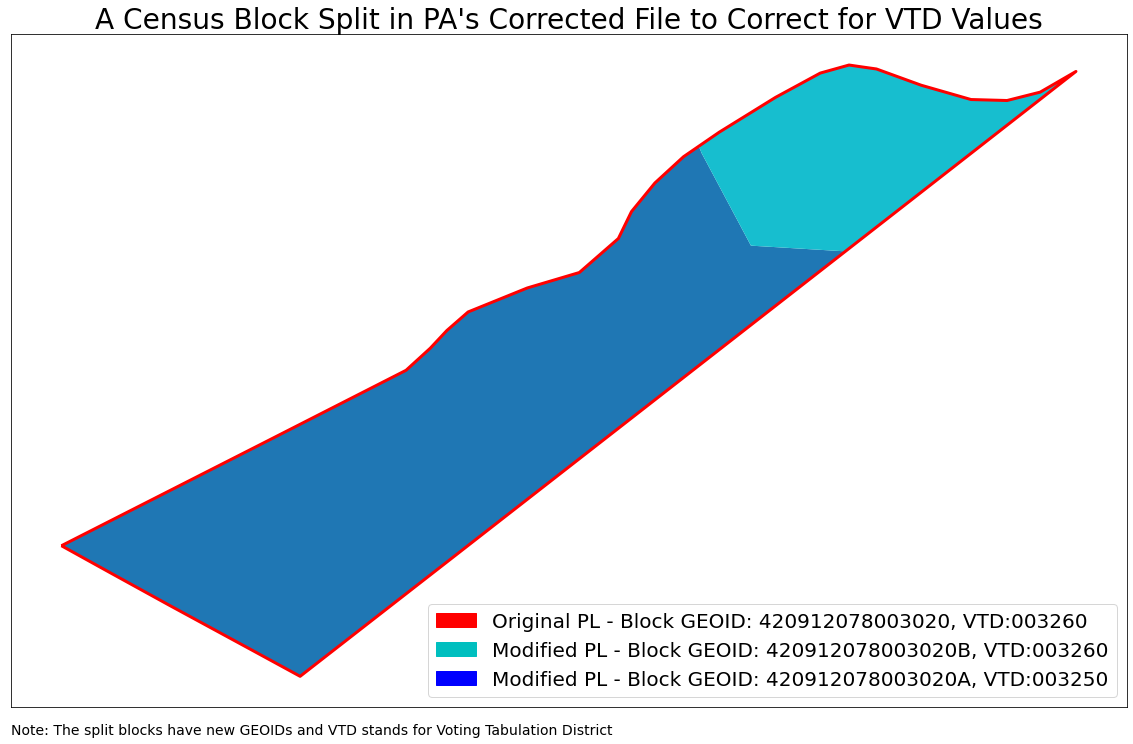

In [84]:
ax = pa_pl_census[pa_pl_census["GEOID20"]=='420912078003020'].boundary.plot(figsize = (20,20), color = "red", linewidth = 3)
pa_adjusted_geoms[pa_adjusted_geoms["GEOID20"].str.contains('420912078003020')].plot(ax = ax, column = "GEOID20", legend = True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
red_patch = mpatches.Patch(color='red', label='Original PL - Block GEOID: 420912078003020, VTD:003260')
blue_patch = mpatches.Patch(color='c', label='Modified PL - Block GEOID: 420912078003020B, VTD:003260')
light_blue_patch = mpatches.Patch(color='blue', label='Modified PL - Block GEOID: 420912078003020A, VTD:003250')
#ax.annotate(text = "Note:", xy=(-.009, .0035), ha='center', fontsize = 20, color = "lightgreen", weight='bold')
ax.text(0, -0.04, 'Note: The split blocks have new GEOIDs and VTD stands for Voting Tabulation District', transform=ax.transAxes, fontsize = 14)

ax.legend(handles=[red_patch, blue_patch, light_blue_patch], fontsize = 20, loc="lower right")
ax.set_title("A Census Block Split in PA's Corrected File to Correct for VTD Values", fontsize = 28)

#ax.annotate("Note: The blocks have new GEOIDs and that VTD stands for Voting Tabulation District", -1.5)
#ax.annotate("'VTD' stands for Voting Tabulation District", -2)
ax.figure.savefig("./example_map_pa_split.png",bbox_inches="tight")